# Road Surface Sediment Storage
Amanda Manaster  
*2019.12.18*  

---
When a truck passes, two processes occur: **crushing and pumping**.  
    &emsp;*Crushing* creates more fine sediment in the existing sediment matrix by breaking down larger particles.  
    &emsp;*Pumping* makes fine sediment available for transport (i.e., adds the fine sediment to the transport available fines storage layer). 

We can think of the total storage as:  
$S=S_f+S_s+S_b$  
    &emsp;$S_f$= transport available fines (TAF) storage term [$m$]  
    &emsp;$S_s$= surfacing storage term; combination of fines ($S_{s_f}$), coarse particles ($S_{s_c}$) [$m$]  
    &emsp;$S_b$= ballast storage term; combination of fines, 20-30% ($S_{b_f}$), large rocks, 70-80% ($S_{b_r}$) [$m$]  

And the net mass balance as:  
$∆S=-\frac{V_{s,out}}{A}=-H_{s,out}$

$∆S$ = total change in storage [$m$]  
$V_{s,out}$ = volume of sediment leaving the road prism [$m^3$]  
$A$ = representative area of road [$m^2$]  
$H_{s,out}$ = depth of sediment leaving the road prism [$m$]    

---
## A Tri-Layered Conceptualization:
![](RoadTriLayer.png)  

---  
First, load in packages:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

#from jupyterthemes import jtplot
#jtplot.style(ticks=False, grid=True)

Instantiate empty lists for model run:

In [2]:
storm_depth = []
rainfall_rate = []
delta_t = []
storm_length = []
truck_pass = []
total_t = []

model_end = 876000 #20 yrs = 175200 hrs; 100 yrs = 876000 hrs

Run a model loop to generate random rainfall based on averages from Peter Eagleson's _Ecohydrology_ and to generate stochastic truck passes:

In [3]:
np.random.seed(1) #Use seed to ensure consistent results with each run
time = 0 #model time; initial
T_b = 0  #average inter-storm duration; initial
T_r = 0  #average storm duration; initial
r = 0    #average intensity; initial

while time < model_end:
    truck = 0
    time_step = T_b+T_r
    
    if time_step/24 >= 1:
        day = int(time_step/24)
        frac_day = time_step/24 - int(time_step/24)
        
        for num in range(day):
            truck += np.random.randint(0,10)
            
        truck += round(np.random.randint(0,10)*frac_day)
    else:
        frac_day = time_step/24 - int(time_step/24)
        truck = round(np.random.randint(0,10)*frac_day)
    
    storm_length.append(T_r)             #length of storm
    storm_depth.append(r*T_r)            #depth of storm
    rainfall_rate.append(r)              #rate of rainfall
    delta_t.append(time_step)            #length of each time step; variable
    total_t.append(time)                 #model time
    truck_pass.append(truck)             #number of truck passes
    
    T_b = np.random.exponential(90.5)    #average inter-storm duration, hr
    T_r = np.random.exponential(2.705*2) #average storm duration, hr
    r = np.random.exponential(2)         #average intensity, mm/hr
    
    time += T_b+T_r

Because we have a hefty data set, we wrap these data in a Pandas dataframe for ease of plotting.

In [4]:
df = pd.DataFrame() #Create dataframe

df['time'] = total_t
df['delta_t'] = delta_t
df['day'] = np.divide(total_t,24).astype('int64')
df['storm_depth'] = storm_depth
df['rainfall_rate'] = rainfall_rate
df['storm_length'] = storm_length
df['truck_pass'] = truck_pass

day0 = datetime(2018, 10, 1)
df.set_index(pd.DatetimeIndex([day0+timedelta(hours=time) for time in df.time]), inplace=True) #Set index of dataframe

df.head()

,time,delta_t,day,storm_depth,rainfall_rate,storm_length,truck_pass
2018-10-01 00:00:00.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
2018-10-23 18:04:10.686243,546.069635,546.069635,22,4.000265,0.274217,14.587945,104
2018-10-29 21:30:25.616920,693.507116,147.437481,28,0.769405,1.460255,0.526897,30
2018-10-30 09:50:00.511037,705.833475,12.326359,29,18.734350,6.334918,2.957315,5
2018-10-31 07:36:04.991436,727.601387,21.767911,30,0.567193,0.306582,1.850051,4


We resample the data to get a daily time step.

In [5]:
df_day = df.resample('D').sum().fillna(0)
df_day.truck_pass = df_day.truck_pass.round()
df_day['day'] = np.arange(0, len(df_day), 1)
df_day.tail()

,time,delta_t,day,storm_depth,rainfall_rate,storm_length,truck_pass
2118-08-31,0.000000,0.000000,36493,0.000000,0.000000,0.000000,0
2118-09-01,0.000000,0.000000,36494,0.000000,0.000000,0.000000,0
2118-09-02,0.000000,0.000000,36495,0.000000,0.000000,0.000000,0
2118-09-03,875922.378062,359.829588,36496,8.388102,1.312567,6.390610,62
2118-09-04,875948.342647,25.964585,36497,4.699861,2.462546,1.908538,4


And now we can plot the stochastically generated daily rainfall.

In [6]:
#ticklabels = [item.strftime('%Y') for item in df_day.index[::366*2]]
#fig, ax = plt.subplots(figsize=(10,4))
#df_day.plot(y='storm_depth', ax=ax, legend=False, kind='bar', width=7)
#plt.xlabel('Date')
#plt.ylabel('Rainfall (mm)')
#plt.title('Daily rainfall', fontweight='bold', fontsize=14)
#plt.xticks(np.arange(0,366*2*len(ticklabels)+366,366*2), ticklabels, rotation=0)
#plt.tight_layout()
#plt.savefig(r'C:\Users\Amanda\Desktop\Rainfall.png', dpi=300)
#plt.show()

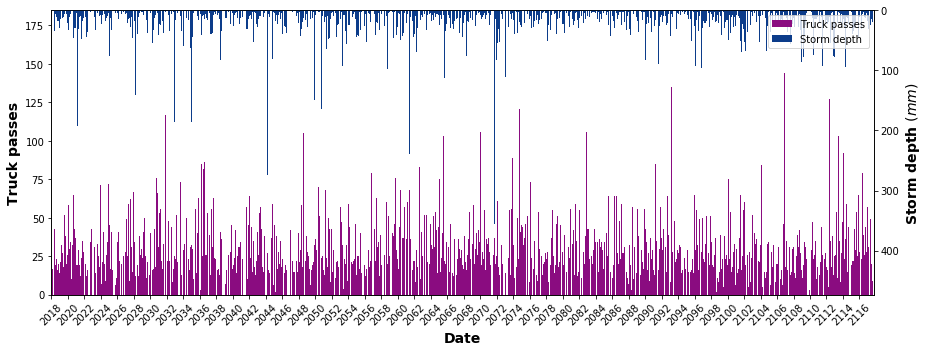

In [7]:
ticklabels = [item.strftime('%Y') for item in df_day.index[::366*2]]

fig, ax = plt.subplots(figsize=(13,5))
df_day.plot(y='truck_pass', ax=ax, color = '#8a0c80', legend=False, label='Truck passes', 
            kind='bar', width=7)
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Truck passes', fontsize=14, fontweight='bold')
ax.grid(False)

ax1 = ax.twinx()
df_day.plot(y='storm_depth', ax=ax1, color='#0c3c8a', legend=False, label='Storm depth', kind='bar', width=7)
ax1.set_ylabel(r'Storm depth $(mm)$', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(False)

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
ax.set_xticks(np.arange(0,366*2*len(ticklabels),366*2))
ax.set_xticklabels(ticklabels, rotation=45)
plt.tight_layout()
#plt.savefig(r'C:\Users\Amanda\Desktop\Rainfall_Truck.png', dpi=300)

plt.show()

Now that we have the time step of the model, our rainfall, and our truck passes, we can start to calculate sediment transport rates:

In [8]:
#Define constants
L = 4.57 #representative segment of road, m
rho_w = 1000 #kg/m^3
rho_s = 2650 #kg/m^3
g = 9.81 #m/s^2
S = 0.0825 #m/m; 8% long slope, 2% lat slope
tau_c = 0.0939 #N/m^2; assuming d50 is approx. 0.0580 mm; value from https://pubs.usgs.gov/sir/2008/5093/table7.html
d50 = 5.8e-5 #m
d95 = 0.07 #m
n_s = 0.03 #approx Manning's n for grains

And finally, we can look at the evolution of the road through time!

## Create loop that goes through model time:
1. Create fines storage, $S_{f_0}$; surfacing storage, $S_{s_0}$; and ballast storage, $S_{b_0}$:  
    &emsp;$S_{f_{0}} = 0$  
    
    &emsp;$S_{s_0}=S_{{sc}_0}+S_{{sf}_0}$     
    &emsp;&emsp;$S_{s_{f_0}}=h_{s_0}*f_{sf_0}$   
    &emsp;&emsp;$S_{s_{c_0}}=h_{s_0}*f_{sc_0}$  
    
    &emsp;$S_{b_0}=S_{{bf}_0}+S_{{bc}_0}$  
    &emsp;&emsp;$S_{{bf}_0}=h_{b_0}*f_{bf_0}$   
    &emsp;&emsp;$S_{{bc}_0}=h_{b_0}*f_{bc_0}$  


2. Loop through dataframe:
    * Calculate $S_{f_i}$                 
    * Calculate $S_{s_i}$  
    * Calculate $S_{b_i}$       
    
For simplicity, we'll assume the following:  
    &emsp;$h_{s_0}$ = 0.23 [m] (https://www.fhwa.dot.gov/construction/pubs/ots15002.pdf, A4 Table 3)   
    &emsp;$f_{sf_0}$ = 0.275 [-] (from Palix watershed analysis)  
    &emsp;$f_{sc_0}$ = 0.725 [-] (from Palix watershed analysis)  
    &emsp;$h_{b_0}$ = 0.60 [m]  
    &emsp;$f_{bf_0}$ = 0.20 [-]  
    &emsp;$f_{bc_0}$ = 0.80 [-]  

In [9]:
#define constants
h_s = 0.23
f_sf = 0.275
f_sc = 0.725

h_b = 5
f_bf = 0.20
f_br = 0.80

#The following four constants can be adjusted based on observations
kas = 1.37e-7 #crushing constant... value is easily changeable
kab = 1.0e-6
u_p = 4.69e-6 #m (2.14e-5m^3/4.57 m^2)  6 tires * 0.225 m width * 0.005 m length * 3.175e-3 m treads
u_f = 2.345e-5 #m
p = 0.20 #[-] (Applied Hydrogeology 3rd Ed. by C.W. Fetter, Table 3.4)

In [10]:
#Create a new dataframe for our storage calculations
df_storage = pd.DataFrame()

df_storage['time'] = total_t
df_storage['day'] = np.divide(total_t,24).astype('int64')
day0 = datetime(2018, 10, 1)
df_storage.set_index(pd.DatetimeIndex([day0+timedelta(hours=time) for time in df_storage.time]), inplace=True)

In [11]:
#Step 1!
#Initialize numpy arrays for calculations
dS_f = np.zeros(len(df))
S_f = np.zeros(len(df))
S_s = np.zeros(len(df))
S_sc = np.zeros(len(df))
S_sf = np.zeros(len(df))
S_b = np.zeros(len(df))
S_bc = np.zeros(len(df))
S_bf = np.zeros(len(df))
Hs_out = np.zeros(len(df))
q_s = np.zeros(len(df))
h_f = np.zeros(len(df))
k_s = np.zeros(len(df))
H = np.zeros(len(df))
tau = np.zeros(len(df))
shear_stress = np.zeros(len(df))
n = np.zeros(len(df))
f_s = np.zeros(len(df))

n_tp = df.truck_pass.to_numpy()
t = df.delta_t.to_numpy()
t_storm = df.storm_length.to_numpy()
rainfall = df.rainfall_rate.to_numpy()

q_f1 = np.zeros(len(df))
q_f2 = np.zeros(len(df))
q_as = np.zeros(len(df))
q_ab = np.zeros(len(df))
sed_avail = np.zeros(len(df))
sed_cap = np.zeros(len(df))
value = np.zeros(len(df))

#Initial conditions for fines, surfacing, ballast
n[0] = 0.0475*(d95)**(1/6)
f_s[0] = (n_s/n[0])**(1.5)
S_f[0] = 0
S_s[0] = h_s*(f_sf + f_sc)
S_sc[0] = h_s*(f_sc)
S_sf[0] = h_s*(f_sf)
S_b[0] = h_b*(f_bf + f_br)
S_bc[0] = h_b*(f_br)
S_bf[0] = h_b*(f_bf)

In [12]:
#Step 2!
for i in range(1, len(df)):
    q_f1[i] = u_p*(S_sf[i-1]/S_s[i-1])*n_tp[i]/(t[i]*3600)
    q_f2[i] = u_f*(S_bf[i-1]/S_b[i-1])*n_tp[i]/(t[i]*3600)
    q_as[i] = kas*(S_sc[i-1]/S_s[i-1])*n_tp[i]/(t[i]*3600)
    q_ab[i] = kab*(S_bc[i-1]/S_b[i-1])*n_tp[i]/(t[i]*3600)
    
    S_bc[i] = S_bc[i-1] - q_ab[i]*(t[i]*3600)
    S_sc[i] = S_sc[i-1] - q_as[i]*(t[i]*3600)
    
    S_bf[i] = S_bf[i-1] + q_ab[i]*(t[i]*3600) - q_f2[i]*(t[i]*3600)
    S_sf[i] = S_sf[i-1] + q_as[i]*(t[i]*3600) - q_f1[i]*(t[i]*3600) + q_f2[i]*(t[i]*3600)
        
    S_s[i] = S_sc[i] + S_sf[i]
    S_b[i] = S_bc[i] + S_bf[i]
    
    h_f[i] = (1/p)*(q_f1[i]*(t[i]*3600) + S_f[i-1])
    
    if d95 > h_f[i]:
        k_s[i] = d95 - h_f[i]
        n[i] = 0.0475*(k_s[i])**(1/6) #FIX THIS -- f_s should NOT exceed 1!!!!!!!
    else:
        n[i] = n_s
    
    f_s[i] = (n_s/n[i])**(1.5)
    
    #Calculate water depth assuming uniform overland flow
    H[i] = ((n[i]*(rainfall[i]/3.6e6)*L)/(S**(1/2)))**(3/5)
    
    tau[i] = rho_w*g*H[i]*S
    
    #Calculate shear stress
    shear_stress[i] = tau[i]*f_s[i]
    
    #Calculate sediment transport rate
    if (shear_stress[i]-tau_c) >= 0:
        q_s[i] = ((10**(-4.348))/(rho_s*((d50)**(0.811))))*(shear_stress[i]-tau_c)**(2.457)/L
    else:
        q_s[i] = 0

    #Create a condition column based on sediment transport capacity vs sediment supply
    sed_avail[i] = q_f1[i]*(t[i]*3600.)
    sed_cap[i] = q_s[i]*(t_storm[i]*3600.)
    value[i] = (sed_avail[i]-sed_cap[i])
        
    if value[i] < 0:
        Hs_out[i] = np.minimum(sed_avail[i]+S_f[i-1], sed_cap[i])
        dS_f[i] = sed_avail[i] - Hs_out[i]

    else:
        Hs_out[i] = sed_cap[i]
        dS_f[i] = sed_avail[i] - Hs_out[i]

    S_f[i] = S_f[i-1] + dS_f[i] if (S_f[i-1] + dS_f[i]) > 0 else 0
    
#Add all numpy arrays to the Pandas dataframe
df['q_s'] = q_s
df_storage['n'] = n
df_storage['ks'] = k_s
df_storage['water_depth'] = H
df_storage['shear_stress'] = shear_stress
df_storage['hf'] = h_f
df_storage['f_s'] = f_s
df_storage['q_s'] = q_s
df_storage['qf1'] = q_f1
df_storage['qf2'] = q_f2
df_storage['dS_f'] = dS_f
df_storage['S_f'] = S_f
df_storage['S_s'] = S_s
df_storage['S_sc'] = S_sc
df_storage['S_sf'] = S_sf
df_storage['S_b'] = S_b
df_storage['S_bc'] = S_bc
df_storage['S_bf'] = S_bf
df_storage['Hs_out'] = Hs_out
df_storage['sed_avail'] = sed_avail
df_storage['sed_cap'] = sed_cap

1.1485116502616681

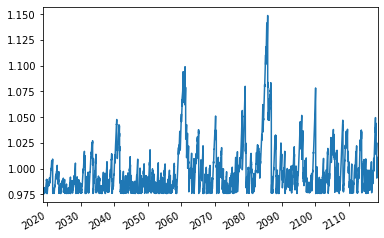

In [13]:
_= df_storage.f_s.plot()
f_s.max()

In [14]:
#Look at our dataframe
df_storage

,time,day,n,ks,water_depth,shear_stress,hf,f_s,q_s,qf1,...,S_f,S_s,S_sc,S_sf,S_b,S_bc,S_bf,Hs_out,sed_avail,sed_cap
2018-10-01 00:00:00.000000,0.000000,0,0.030494,0.000000,0.000000,0.000000,0.000000,0.975814,0.000000e+00,0.000000e+00,...,0.000000,0.230000,0.166750,0.063250,5.000000,4.000000,1.000000,0.000000e+00,0.000000,0.000000e+00
2018-10-23 18:04:10.686243,546.069635,22,0.030445,0.069329,0.000035,0.027462,0.000671,0.978165,0.000000e+00,6.823204e-11,...,0.000134,0.230354,0.166740,0.063614,4.999512,3.999917,0.999595,0.000000e+00,0.000134,0.000000e+00
2018-10-29 21:30:25.616920,693.507116,28,0.030431,0.069135,0.000095,0.074940,0.000865,0.978852,0.000000e+00,7.320505e-11,...,0.000173,0.230455,0.166737,0.063719,4.999372,3.999893,0.999479,0.000000e+00,0.000039,0.000000e+00
2018-10-30 09:50:00.511037,705.833475,29,0.030428,0.069103,0.000228,0.180773,0.000897,0.978966,2.497670e-08,1.461119e-10,...,0.000000,0.230472,0.166736,0.063736,4.999348,3.999889,0.999459,1.794731e-04,0.000006,2.659103e-04
2018-10-31 07:36:04.991436,727.601387,30,0.030492,0.069974,0.000037,0.029322,0.000026,0.975904,0.000000e+00,6.620347e-11,...,0.000005,0.230486,0.166736,0.063750,4.999329,3.999886,0.999444,0.000000e+00,0.000005,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2118-08-15 18:11:15.288985,875466.187580,36477,0.029979,0.063199,0.000096,0.077462,0.006801,1.001069,0.000000e+00,5.397741e-11,...,0.001360,0.415452,0.156532,0.258920,4.392740,3.861374,0.531366,0.000000e+00,0.000006,0.000000e+00
2118-08-17 10:04:45.054317,875506.079182,36479,0.029975,0.063155,0.000020,0.016335,0.006845,1.001243,0.000000e+00,6.105976e-11,...,0.001369,0.415452,0.156532,0.258920,4.392731,3.861371,0.531360,0.000000e+00,0.000009,0.000000e+00
2118-08-19 18:32:54.503549,875562.548473,36481,0.029961,0.062980,0.000113,0.091998,0.007020,1.001939,0.000000e+00,1.725378e-10,...,0.001404,0.415451,0.156531,0.258920,4.392697,3.861361,0.531336,0.000000e+00,0.000035,0.000000e+00
2118-09-03 18:22:41.021611,875922.378062,36496,0.029889,0.062074,0.000088,0.071441,0.007926,1.005575,0.000000e+00,1.398977e-10,...,0.001585,0.415446,0.156528,0.258918,4.392521,3.861306,0.531215,0.000000e+00,0.000181,0.000000e+00


Now, let's plot our data:

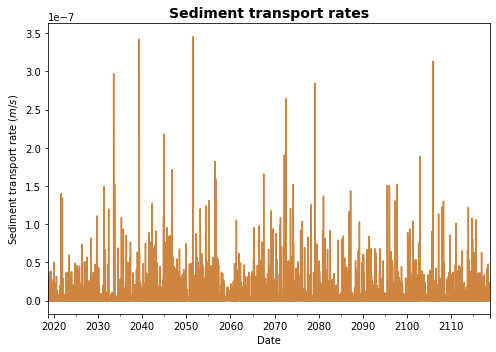

In [15]:
#Resample to daily data again
df_day_sed = df.resample('D').sum().fillna(0)
df_day_sed['day'] = np.arange(0, len(df_day_sed), 1)

#Plot sediment transport rates over time
fig2, ax2 = plt.subplots(figsize=(7,5))
df_day_sed.plot(y='q_s', ax=ax2, color = 'peru', legend=False)
plt.xlabel('Date')
plt.ylabel(r'Sediment transport rate $(m/s)$')
plt.title('Sediment transport rates', fontweight='bold', fontsize=14)
plt.tight_layout()
#plt.savefig(r'C:\Users\Amanda\Desktop\Sediment.png', dpi=300)
plt.show()

In [16]:
df4 = df_storage.resample('D').mean().fillna(method='ffill')
df4['day'] = np.arange(0, len(df4), 1)
df4['S_f_mm'] = df4.S_f*1000
df4['sed_cap_mm'] = df4.sed_cap/1e-3
df4['Hs_out_mm'] = df4.Hs_out/1e-3

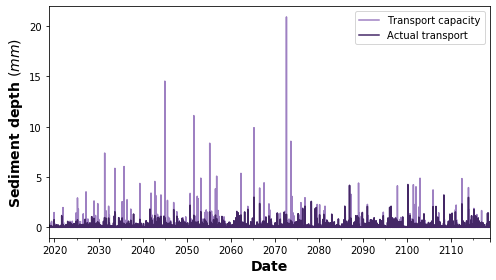

In [33]:
fig13, ax13 = plt.subplots(figsize=(7,4))
df4.sed_cap_mm.plot(color = '#9e80c2', label='Transport capacity')
df4.Hs_out_mm.plot(color='#442766', label='Actual transport')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel(r'Sediment depth $(mm)$', fontsize=14, fontweight='bold')
#plt.ylim(0,8)

fig13.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax13.transAxes)
plt.tight_layout()
#plt.savefig(r'C:\Users\Amanda\Desktop\CapacityVTransport.png', dpi=300)
plt.show()

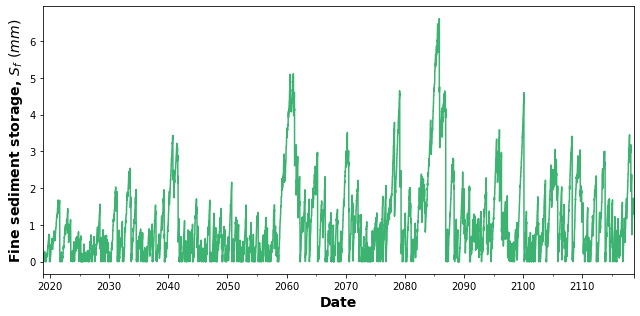

In [32]:
fig3, ax3 = plt.subplots(figsize=(9,4.5))
df4.plot(y='S_f_mm', ax=ax3, color = 'mediumseagreen', legend=False)
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel(r'Fine sediment storage, $S_f$ $(mm)$',fontsize=14, fontweight='bold')
#plt.title('Fine sediment storage', fontweight='bold', fontsize=14)
#plt.ylim(0,1.4)
plt.tight_layout()
#plt.savefig(r'C:\Users\Amanda\Desktop\FineStorage.png', dpi=300)
plt.show()

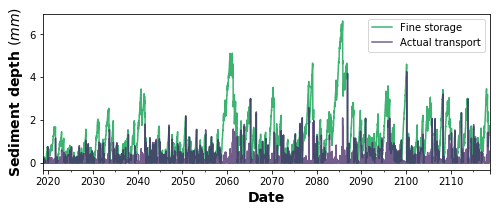

In [31]:
df4['sed_cap_mm'] = df4.sed_cap/1e-3

fig8, ax8 = plt.subplots(figsize=(7,3))
df4.plot(y='S_f_mm', ax=ax8, color = 'mediumseagreen', legend=False, label='Fine storage')
df4.plot(y='Hs_out_mm', ax=ax8, color = '#442766', legend=False, label='Actual transport', alpha=0.75)

ax8.set_xlabel('Date', fontsize=14, fontweight='bold')
ax8.set_ylabel(r'Sediment depth $(mm)$', fontsize=14, fontweight='bold')
#ax8.set_ylim(0, 1.4)

fig8.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax8.transAxes)
plt.tight_layout()
#plt.savefig(r'C:\Users\Amanda\Desktop\CapacityVStorage.png', dpi=300)
plt.show()

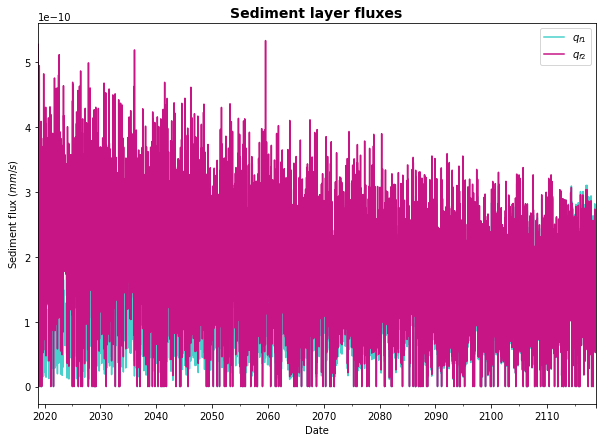

In [20]:
fig10, ax10 = plt.subplots(figsize=(10,7))
df4.plot(y='qf1', ax=ax10, color = 'mediumturquoise', legend=False, label=r'$q_{f1}$')
df4.plot(y='qf2', ax=ax10, color = 'mediumvioletred', legend=False, label=r'$q_{f2}$')

ax10.set_ylabel(r'Sediment flux $(mm/s)$')
ax10.set_xlabel('Date')
fig10.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax10.transAxes)

plt.title('Sediment layer fluxes', fontweight='bold', fontsize=14)
plt.show()

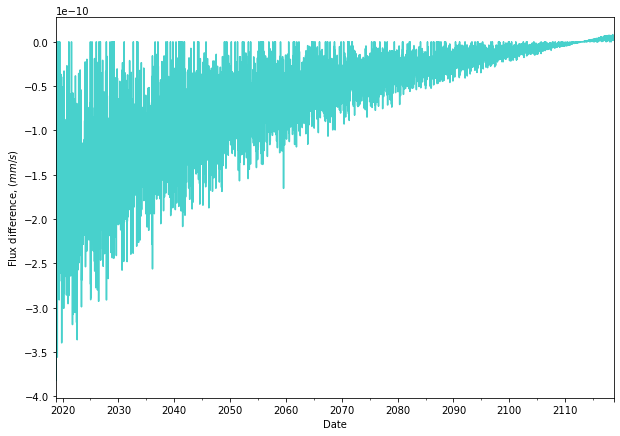

In [21]:
df4['diff'] = df4.qf1-df4.qf2
fig11, ax11 = plt.subplots(figsize=(10,7))
df4.plot(y='diff', ax=ax11, color = 'mediumturquoise', legend=False)
ax11.set_ylabel(r'Flux difference, $(mm/s)$')
ax11.set_xlabel('Date')
plt.show()

In [22]:
df5 = df_storage.resample('D').mean().fillna(method='ffill')
#df5['hour'] = np.arange(0, len(df5), 1)

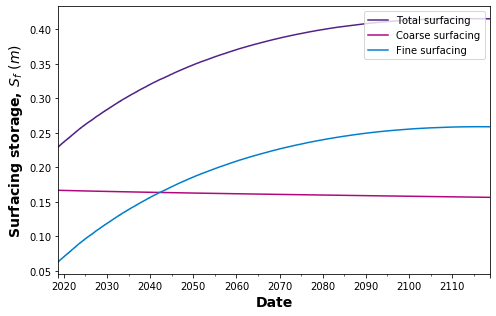

In [30]:
fig5, ax5 = plt.subplots(figsize=(7,4.5))

df5.plot(y='S_s', ax=ax5, color = '#532287', legend=False, label='Total surfacing')
df5.plot(y='S_sc', ax=ax5, color = '#b0077d', legend=False, label='Coarse surfacing')
df5.plot(y='S_sf', ax=ax5, color = '#027fcc', legend=False, label='Fine surfacing')

ax5.set_ylabel(r'Surfacing storage, $S_f$ $(m)$', fontweight='bold', fontsize=14)
#ax5.set_ylim(0, 0.25)
#ax5.set_title('Surfacing storage', fontweight='bold', fontsize=14)
fig5.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax5.transAxes)
plt.xlabel('Date', fontweight='bold', fontsize=14)
plt.tight_layout()
#plt.savefig(r'C:\Users\Amanda\Desktop\SurfStorage.png', dpi=300)
plt.show()

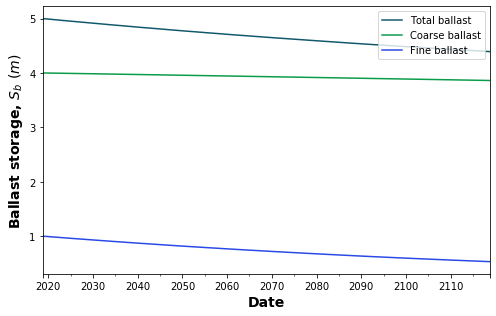

In [24]:
fig7, ax7 = plt.subplots(figsize=(7,4.5))
df5.plot(y='S_b', ax=ax7, color = '#12586b', legend=False, label='Total ballast')
df5.plot(y='S_bc', ax=ax7, color = '#099c49', legend=False, label='Coarse ballast')
df5.plot(y='S_bf', ax=ax7, color = '#2949e6', legend=False, label='Fine ballast')
#ax7.set_ylim(0, 0.7)
plt.xlabel('Date', fontweight='bold', fontsize=14)
plt.ylabel(r'Ballast storage, $S_b$ $(m)$', fontweight='bold', fontsize=14)
fig7.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax7.transAxes)
#plt.title('Ballast storage', fontweight='bold', fontsize=14)
plt.tight_layout()
#plt.savefig(r'C:\Users\Amanda\Desktop\BalStorage.png', dpi=300)
plt.show()

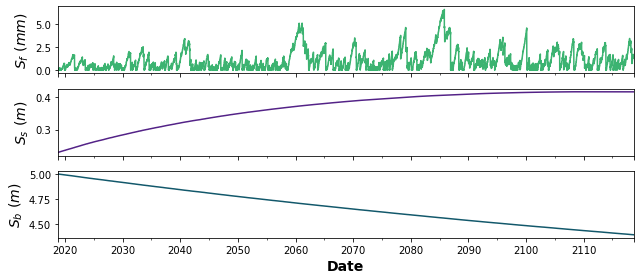

In [25]:
fig10, ax10 = plt.subplots(3, figsize=(9,4), sharex=True)
df4.plot(y='S_f_mm', ax=ax10[0], color = 'mediumseagreen', legend=False, label='TAF elevation')
df5.plot(y='S_s', ax=ax10[1], color = '#532287', legend=False, label='Surfacing elevation')
df5.plot(y='S_b', ax=ax10[2], color = '#12586b', legend=False, label='Ballast elevation')

plt.xlabel('Date', fontweight='bold', fontsize=14)
ax10[0].set_ylabel(r'$S_f$ $(mm)$', fontweight='bold', fontsize=14)
ax10[1].set_ylabel(r'$S_s$ $(m)$', fontweight='bold', fontsize=14)
ax10[2].set_ylabel(r'$S_b$ $(m)$', fontweight='bold', fontsize=14)
plt.tight_layout()
#plt.savefig(r'C:\Users\Amanda\Desktop\100yrs.png', dpi=300)
plt.show()

In [26]:
#Subset data by water year
yr_1 = df_storage.Hs_out['2018-10-01':'2019-09-30'].sum()
yr_2 = df_storage.Hs_out['2019-10-01':'2020-09-30'].sum()
yr_3 = df_storage.Hs_out['2020-10-01':'2021-09-30'].sum()
yr_4 = df_storage.Hs_out['2021-10-01':'2022-09-30'].sum()
yr_5 = df_storage.Hs_out['2022-10-01':'2023-09-30'].sum()
yr_6 = df_storage.Hs_out['2023-10-01':'2024-09-30'].sum()
yr_7 = df_storage.Hs_out['2024-10-01':'2025-09-30'].sum()
yr_8 = df_storage.Hs_out['2025-10-01':'2026-09-30'].sum()
yr_9 = df_storage.Hs_out['2026-10-01':'2027-09-30'].sum()
yr_10 = df_storage.Hs_out['2027-10-01':'2028-09-30'].sum()
yr_11 = df_storage.Hs_out['2028-10-01':'2029-09-30'].sum()
yr_12 = df_storage.Hs_out['2029-10-01':'2030-09-30'].sum()
yr_13 = df_storage.Hs_out['2030-10-01':'2031-09-30'].sum()
yr_14 = df_storage.Hs_out['2031-10-01':'2032-09-30'].sum()
yr_15 = df_storage.Hs_out['2032-10-01':'2033-09-30'].sum()
yr_16 = df_storage.Hs_out['2033-10-01':'2034-09-30'].sum()
yr_17 = df_storage.Hs_out['2034-10-01':'2035-09-30'].sum()
yr_18 = df_storage.Hs_out['2035-10-01':'2036-09-30'].sum()
yr_19 = df_storage.Hs_out['2036-10-01':'2037-09-30'].sum()
yr_20 = df_storage.Hs_out['2037-10-01':'2038-09-30'].sum()


#Multiply Hs_out
sed_area = np.multiply([yr_1, yr_2, yr_3, yr_4, yr_5, yr_6, yr_7, \
                        yr_8, yr_9, yr_10, yr_11, yr_12, yr_13, yr_14, \
                        yr_15, yr_16, yr_17, yr_18, yr_19, yr_20], L)
sed_load = np.multiply(sed_area, rho_s)
years = [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, \
         2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038]

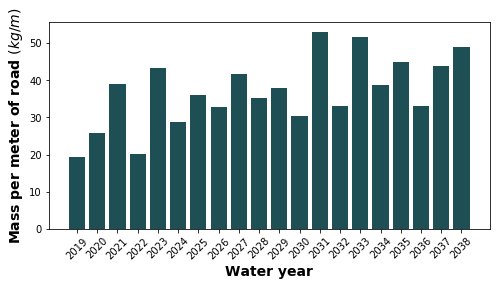

In [27]:
ticks = years
fig8, ax8 = plt.subplots(figsize=(7,4))
plt.bar(years, sed_load, color = '#1d4f54')
plt.xlabel('Water year', fontweight='bold', fontsize=14)
plt.ylabel(r'Mass per meter of road $(kg/m)$', fontweight='bold', fontsize=14)
#plt.title('Yearly sediment load per meter of road', fontweight='bold', fontsize=14)
plt.xticks(range(ticks[0],ticks[len(ticks)-1]+1), ticks, rotation=45)
plt.tight_layout()
#plt.savefig(r'C:\Users\Amanda\Desktop\AnnualYield.png', dpi=300)
plt.show()

And do a sanity check. (i.e., is mass conserved?)

In [28]:
sed_sum_m2 = df_storage.Hs_out.sum()
sed_sum_kg_m = sed_sum_m2*rho_s*L
round(sed_sum_kg_m)

5092.0

In [29]:
s = (df_storage.S_s[0]-df_storage.S_s[len(df_storage)-1])
b = (df_storage.S_b[0]-df_storage.S_b[len(df_storage)-1])
f = (df_storage.S_f[0]-df_storage.S_f[len(df_storage)-1])

round((s+b+f)*rho_s*L)

5092.0